# TP6 - Analyse de données sous `Python`

#### Analyse de Données Massives - Master 1ère année

Nous utilisons dans ce TP le module [`scikit-learn`](http://scikit-learn.org/), dédié au *Machine Learning*. Pour mieux la découvrir, nous allons réaliser une étude de cas, avec les données `iris`.

Dans cette étude, nous allons chercher à savoir s'il existe différentes sous-espèces d'iris. Pour cela, nous allons procéder par étapes ::

1. Visualisation des données, via une **ACP**
1. Classification non-supervisée interne à chaque espèce, via **DBSCAN**
1. Analyse des résultats

Dans un premier temps, il va nous falloir importer les données (`iris`) que nous allons utiliser (via la librairie `pydataset`). Nous allons aussi utiliser d'autres librairies (telles que `seaborn`, `numpy`, `matplotlib` et `pandas`).

Nous importerons les éléments de `scikit-learn` (module `sklearn`) au fur et à mesure.

In [1]:
from pydataset import data
iris = data("iris")

import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white")

%matplotlib inline

Pour rappel, la table se présente comme ceci :

In [2]:
iris.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


## ACP

Dans le sous-module `decomposition`, nous allons importer la fonction [`PCA()`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). Le fonctionnement de celle-ci est similaire à toutes les autres dans `scikit-learn`. 

1. On créé d'abord un objet (nommé ici `pca`) qui va contenir le résultat de l'ACP. Dans la fonction `PCA()`, on pourra indiquer les paramètres tels que le nombre de composants à retenir (`n_components`) ou la méthode de calcul (`svd_solver`).
2. Ensuite, on ajuste (*fit*  en anglais) sur des données avec la fonction `fit()` de l'objet précédemment créé. Dans cette fonction, nous devons donc passer les données à utiliser.

Si l'on souhaite une ACP normée, il nous faut standardiser les données en amont, avec la fonction `scale()` du sous-module `preprocessing` (importée aussi ici). Bien évidemment, il ne faut passer que des variables quantitatives.

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

pca = PCA()
pca.fit(scale(iris[iris.columns[:4]]))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

L'objet `pca` comprend maintenant un certain nombre d'objets et de fonctions. Le premier objet est le tableau des variances expliquées (`explained_variance_`) par chaque dimension, et le ratio (proportion) de variance expliquée par dimension (`explained_variance_ratio_`).

In [4]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[ 2.91849782  0.91403047  0.14675688  0.02071484]
[ 0.72962445  0.22850762  0.03668922  0.00517871]


Bien évidemment, il est possible (et préférable) de faire un tableau récapitulatif, avec les valeurs propres, les proportions de variance expliquée simples et cumulées. Voici un petit code permettant de faire ceci.

In [5]:
eig = pandas.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(4)], 
        "Valeur propre" : pca.explained_variance_,
        "% variance expliquée" : numpy.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : numpy.round(numpy.cumsum(pca.explained_variance_ratio_) * 100)
    },
    columns = ["Dimension", "Valeur propre", "% variance expliquée", "% cum. var. expliquée"]
)
eig

,Dimension,Valeur propre,% variance expliquée,% cum. var. expliquée
0,Dim1,2.918498,73.0,73.0
1,Dim2,0.914030,23.0,96.0
2,Dim3,0.146757,4.0,99.0
3,Dim4,0.020715,1.0,100.0


L'idée est de représenter graphiquement ces proportions de variances expliquées (qu'on passe en pourcentage par convenance).

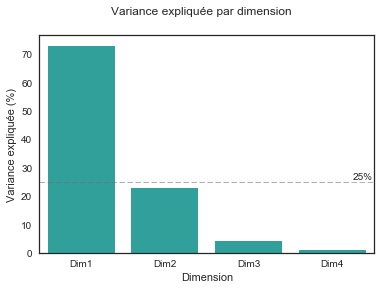

In [6]:
g_eig = seaborn.barplot(x = "Dimension", 
                y = "% variance expliquée",
                palette = ["lightseagreen"],
                data = eig)
g_eig.set(ylabel = "Variance expliquée (%)")
g_eig.figure.suptitle("Variance expliquée par dimension")
seaborn.plt.axhline(y = 25, linewidth = .5, color = "dimgray", linestyle = "--") # 25 = 100 / 4 (nb dimensions)
seaborn.plt.text(3.25, 26, "25%")

On remarque ici qu'avec seulement deux dimensions suffisent à expliquer 96 %  de la variance des données. Nous allons maintenant calculer les coordonnées des iris sur les dimensions, avec la fonction `transform()` de l'objet `pca`.

In [7]:
iris_pca = pca.transform(iris[iris.columns[:4]])

Afin de manipuler plus facilement l'objet obtenu par la suite, nous allons créer un `DataFrame` `pandas` en ne prenant que les deux premières dimensions, ainsi que les espèces.

In [8]:
# Transformation en DataFrame pandas
iris_pca_df = pandas.DataFrame({
    "Dim1" : iris_pca[:,0], 
    "Dim2" : iris_pca[:,1], 
    "Species" : iris.Species
})

# Résultat (premières lignes)
iris_pca_df.head()

,Dim1,Dim2,Species
1,2.640270,5.204041,setosa
2,2.670730,4.666910,setosa
3,2.454606,4.773636,setosa
4,2.545517,4.648463,setosa
5,2.561228,5.258629,setosa


Il est maintenant possible de représenter les données sur le premier plan factoriel, en ajoutant bien évidemment l'information sur les espèces.

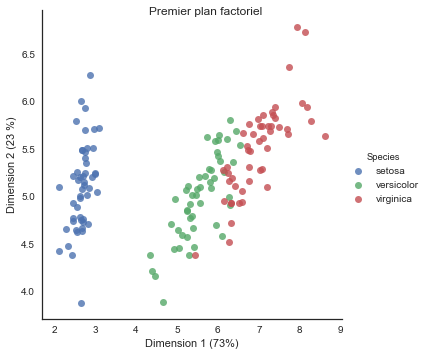

In [9]:
g_pca = seaborn.lmplot("Dim1", "Dim2", hue = "Species", data = iris_pca_df, fit_reg = False)
g_pca.set(xlabel = "Dimension 1 (73%)", ylabel = "Dimension 2 (23 %)")
g_pca.fig.suptitle("Premier plan factoriel")

Il est aussi possible de différencier l'affichage de ce premier plan par espèce, grâce à l'option `col` de `lmplot()`

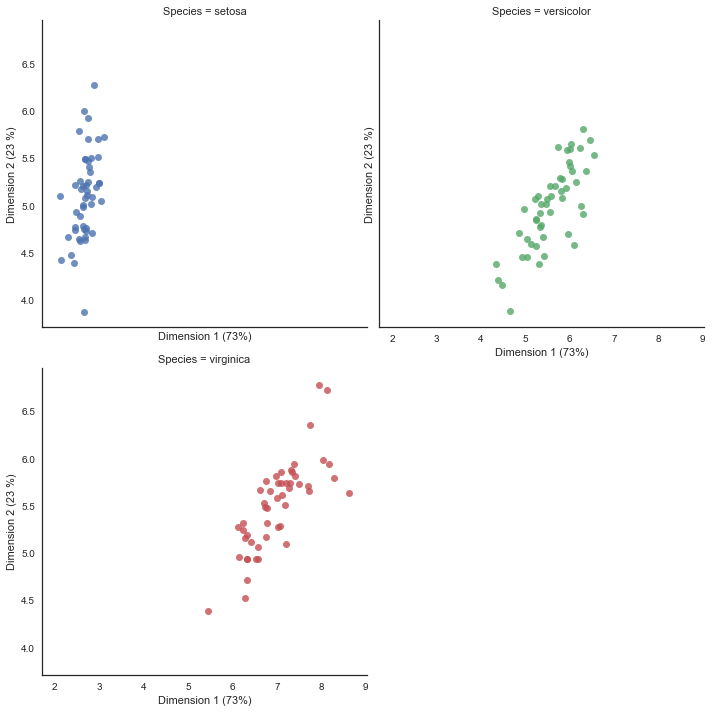

In [10]:
g_pca2 = seaborn.lmplot("Dim1", "Dim2", hue = "Species", col = "Species", col_wrap = 2, data = iris_pca_df, fit_reg = False)
g_pca2.set(xlabel = "Dimension 1 (73%)", ylabel = "Dimension 2 (23 %)")

## DBSCAN

[`DBSCAN`](https://fr.wikipedia.org/wiki/DBSCAN) est un algorithme de classification non supervisée, basé sur la densité. Il est intéressant car il ne nécessite pas de connaître le nombre de classes, mais une estimation de la densité (globale) des données. En effet, les points proches (distance inférieure à $\varepsilon$) sont consiédérés dans la même classe. Si toutefois cette classe comporte au moins un cetain nombre de points au final. Si ce n'est pas le cas, les points sont considérés comme *outliers* et mis à part.

Nous utilisons ici la fonction [`DBSCAN()`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) du sous-module `cluster`. Celle-ci peut prendre en paramètre, entre autres, la valeur de $\varepsilon$ (`eps`, `.5` par défaut) et le nombre minimal d'objets dans une classe (`min_samples`, `5` par défaut).

Puis nous ajustons les données standardisées (pour ne pas donner plus d'influences à une variable qu'à une autre).

In [11]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps = .6, min_samples = 3)
db.fit(scale(iris[iris.columns[:4]]))

DBSCAN(algorithm='auto', eps=0.6, leaf_size=30, metric='euclidean',
    min_samples=3, n_jobs=1, p=None)

Les classes dont contenues dans l'objet `labels_` de `db`. On a pour chaque individu sa classe (de $0$ à $K-1$ pour $K$ classes obtenues). Les *outliers* sont étiquettés $-1$ .

In [12]:
db.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  2,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
        3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  3,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  2,  1,  1,  1,
        1,  1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

On peut faire un tableau récapitulatif des effectifs par classes.

In [13]:
eff = numpy.unique(db.labels_, return_counts = True)
pandas.DataFrame({
    "Classe" : eff[0],
    "Effectif" : eff[1]
})

,Classe,Effectif
0,-1,9
1,0,49
2,1,86
3,2,3
4,3,3


Pour la représentation des données, on ajoute ces labels de classe aux projections des iris sur le premier plan factoriel.

In [14]:
iris_pca_db = iris_pca_df.assign(Labels = db.labels_)

On peut ainsi représenter les données en fonction des espèces et des classes obtenues.

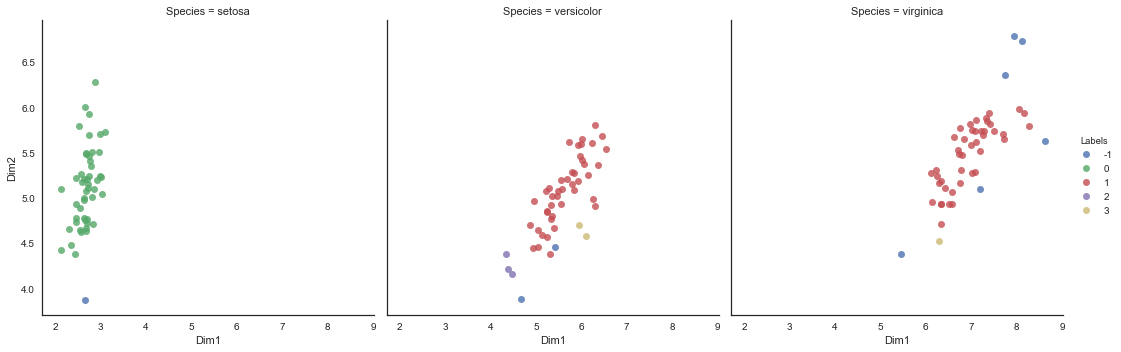

In [15]:
seaborn.lmplot("Dim1", "Dim2", hue = "Labels", col = "Species", data = iris_pca_db, fit_reg = False)

On peut aussi *splitter* le graphique en ligne pour chaque classe.

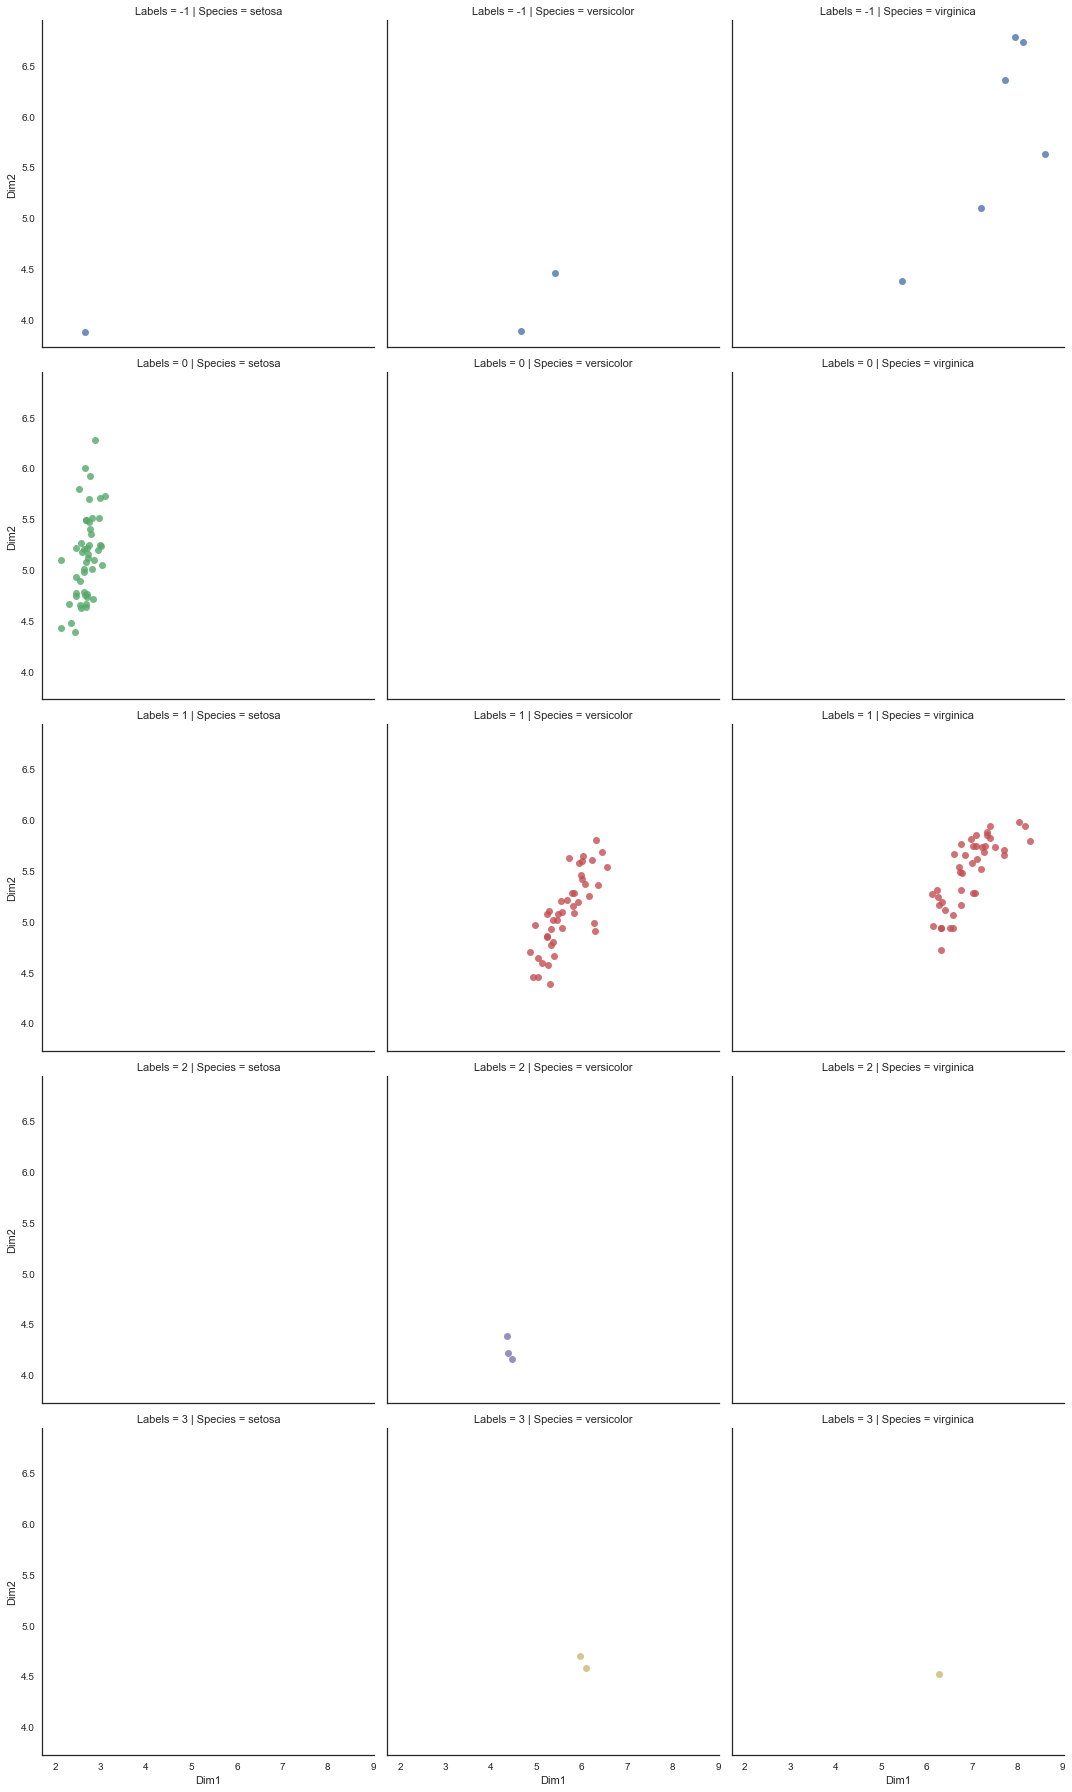

In [16]:
seaborn.lmplot("Dim1", "Dim2", hue = "Labels", col = "Species", row = "Labels", data = iris_pca_db, fit_reg = False)

## Exercice

Nous allons utiliser les données [`pendigits`](https://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits) de l'*UCI Machine Learning Repository*. Ces données représentent le tracé des chiffres de 0 à 9 par plusieurs personnes. Pour chaque tracé, nous n'avons au final que les coordonnées $(X,Y)$ de 8 points et le chiffre tracé.

Voici ci dessous comment importer les données directement.

In [17]:
pen_tes = pandas.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tes", 
                          header=None)
pen_tra = pandas.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tra", 
                          header=None)
pen = pen_tes.copy().append(pen_tra, ignore_index = True)
print(pen.shape)
pen.head()

(10992, 17)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,88,92,2,99,16,66,94,37,70,0,0,24,42,65,100,100,8
1,80,100,18,98,60,66,100,29,42,0,0,23,42,61,56,98,8
2,0,94,9,57,20,19,7,0,20,36,70,68,100,100,18,92,8
3,95,82,71,100,27,77,77,73,100,80,93,42,56,13,0,0,9
4,68,100,6,88,47,75,87,82,85,56,100,29,75,6,0,0,9


Comme vous le pouvez le remarquer, les noms des variables ne sont pas renseignés. Celles-ci sont $(x_j, y_j)_{j = 1,\ldots,8}$ et le chiffre. On va donc déjà créer le vecteur correspondant.

In [18]:
a = [c + n for c, n in zip(["x", "y"] * 8, [str(x) for x in range(1, 9) for i in range(2)])]
a.append("chiffre")
print(a)

['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'chiffre']


On va ensuite renommer les colonnes avec ce vecteur.

In [19]:
pen.columns = a
pen.head()

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,chiffre
0,88,92,2,99,16,66,94,37,70,0,0,24,42,65,100,100,8
1,80,100,18,98,60,66,100,29,42,0,0,23,42,61,56,98,8
2,0,94,9,57,20,19,7,0,20,36,70,68,100,100,18,92,8
3,95,82,71,100,27,77,77,73,100,80,93,42,56,13,0,0,9
4,68,100,6,88,47,75,87,82,85,56,100,29,75,6,0,0,9


Et pour la suite, nous allons créer une variable contenant les chiffres mais en tant que chaîne de caractère.

In [20]:
pen = pen.assign(chiffre_str = [str(c) for c in pen.chiffre])

Par la suite, nous aurons besoin d'accéder aux $x_j$ uniquement, ou aux $y_j$, voire aux deux. Nous créons donc des vecteurs avec les noms de variables. 

In [21]:
xN = ["x" + str(i + 1) for i in range(8)]
print(xN)
yN = ["y" + str(i + 1) for i in range(8)]
print(yN)
xyN = [a + b for a,b in zip(["x", "y"] * 8, [str(i + 1) for i in range(8) for j in range(2)])]
print(xyN)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8']
['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8']


Ces données ont l'avantage d'être graphique. Nous allons donc représenter le premier tracé, qui est un $8$.

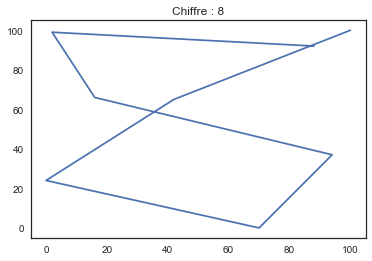

In [22]:
x = pen.loc[0, xN]
y = pen.loc[0, yN]
chiffre = pen.loc[0, "chiffre"]
plt.plot(x, y)
plt.title("Chiffre : " + str(chiffre))

Nous allons régulièrement utiliser ce code, donc nous allons le stocker dans une fonction nommée `dessin()`. Dans celle-ci, nous allons mettre en paramètre les $x_j$ et les $y_j$, le chiffre, ainsi qu'un graphique dans lequel nous allons mettre le dessin. Ceci nous sera utile pour faire plusieurs représentations de chiffres.

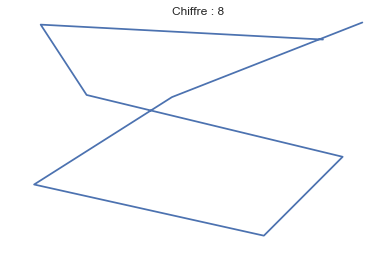

In [23]:
def dessin(p, x, y, chiffre):
    p.plot(x, y)
    p.set_title("Chiffre : " + str(chiffre))
    p.axis("off")
    p.set_xlim([-1, 101])
    p.set_ylim([-1, 101])

fig, ax = plt.subplots()
dessin(ax, x, y, chiffre)

Ensuite, nous créons une liste de `DataFrame`, un pour chaque chiffre. La fonction `query()` permet donc de sélectionner des lignes d'un `DataFrame` en fonction d'une condition (ici, `chiffre` égal 0, 1, ..., 9). Pour éviter les problèmes d'index plus tard, nous devons les réinitialiser pour chaque `DataFrame`, avec la fonction `reset_index()`, en mettant `drop` à vrai. Ceci permet d'oublier les numéros de ligne du `DataFrame` global et que ceux-ci recommencent de 0 pour chaque sous-ensemble.

In [24]:
sub = [pen.query("chiffre == " + str(i)).reset_index(drop = True) for i in range(10)]

Nous voulons maintenant représenter chaque premier exemple de chaque chiffre. Pour cela, nous recherchons la première ligne (`index = 0`) pour chaque sous-ensemble précédemment créé. Et pour simplifier le travail ensuite, nous renvoyons pour chaque chiffre, trois éléments : les $x_j$, les $y_j$ et le chiffre.

In [25]:
subxyc = [[s.loc[0, xN], s.loc[0, yN], s.loc[0, "chiffre"]] for s in sub]

Puis, nous créons une figure (en spécifiant la taille). Et pour chaque chiffre, nous ajoutons un graphique à la figure avec la fonction `add_subplot()`. Celle-ci prend trois paramètres : le nombre de lignes, le nombre de colonnes et le numéro de placement du prochain graphique. Grâce à l'utilisation de la fonction  `dessin()` et de l'objet `subxyc`, la réalisation est simple.

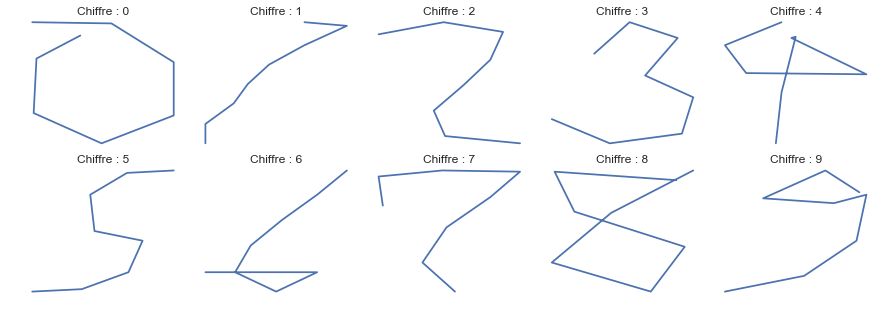

In [26]:
fig = plt.figure(figsize = (15, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    dessin(ax, subxyc[i][0], subxyc[i][1], subxyc[i][2])

Le but de ce TP va être de réfléchir à comment répondre à la question suivante :

> Existe-t'il plusieurs façons d'écrire chaque chiffre ?

Pour cela, nous allons dérouler les étapes suivantes :

1. Calculer la moyenne de chaque coordonnée $x_j$ et $y_j$, pour chaque chiffre
1. Représenter le tracé des *chiffres moyens* (i.e. en prenant les coordonnées moyennes donc)
    - Améliorer éventuellement la fonction `dessin()` pour ajouter, si demandé, les numéros des points
1. Réaliser une ACP sur les données (en comparant avec ou sans standardisation)
1. Représenter les chiffres sur le plan factoriel
    - sur un seul graphique
    - avec un graphique par chiffre, sur la même figure
1. Réaliser une classification via DBSCAN pour chaque chiffre
    - choisir un $\varepsilon$ et un nombre minimal de points
    - créer une fonction prenant en paramètre les valeurs ci-dessus à tester et qui réalise les opérations suivantes :
        - calcul de la partition
        - affichage de la répartition des classes
        - représentation des classes sur le plan factoriel (un graphique par classe éventuellement)
        - représentation des tracés moyens pour chaque classe afin de mieux comprendre les différences entre les classes
